##### Unsupervised learning . K-means

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from kneed import KneeLocator
from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch

In [2]:
# load Barcelona weather_data
df=pd.read_csv('barcelona_rain.csv',index_col=[0])
df=df[['fecha','sol','tmed','presMax','velmedia','dir','humidity','prec']]
#select only month from the date
df['mes'] = pd.DatetimeIndex(df['fecha']).month
df=df.drop(['fecha'],axis=1)
df1=df.copy()
df

,sol,tmed,presMax,velmedia,dir,humidity,prec,mes
3,0.0,7.4,981.3,1.9,27.0,84.0,0.0,3
4,0.7,10.7,980.9,0.8,32.0,84.0,0.0,3
5,0.2,8.9,980.0,1.4,32.0,79.0,0.0,3
6,7.9,10.6,980.0,1.9,32.0,82.0,0.0,3
7,9.4,11.5,978.1,2.2,32.0,76.0,0.0,3
...,...,...,...,...,...,...,...,...
13125,13.1,24.8,968.5,6.4,21.0,68.0,0.0,7
13126,12.5,25.2,968.8,3.1,8.0,72.0,0.0,7
13127,12.9,25.1,968.8,3.1,20.0,72.0,0.0,7
13128,7.4,25.6,966.1,2.2,6.0,78.0,0.0,7


##### Prepare the data

In [3]:
df['tmed']=df['tmed'].astype(int)
df.sol = df.sol.round()
df.velmedia = df.velmedia.round()

In [4]:
from sklearn.preprocessing import MinMaxScaler

#list for cols to scale
cols_to_scale = ['sol','tmed','presMax','velmedia','humidity']


#create and fit scaler
scaler = MinMaxScaler()
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])
df

,sol,tmed,presMax,velmedia,dir,humidity,prec,mes
3,0.000000,0.277778,0.774704,0.10,27.0,0.828947,0.0,3
4,0.071429,0.361111,0.766798,0.05,32.0,0.828947,0.0,3
5,0.000000,0.305556,0.749012,0.05,32.0,0.763158,0.0,3
6,0.571429,0.361111,0.749012,0.10,32.0,0.802632,0.0,3
7,0.642857,0.388889,0.711462,0.10,32.0,0.723684,0.0,3
...,...,...,...,...,...,...,...,...
13125,0.928571,0.750000,0.521739,0.30,21.0,0.618421,0.0,7
13126,0.857143,0.777778,0.527668,0.15,8.0,0.671053,0.0,7
13127,0.928571,0.777778,0.527668,0.15,20.0,0.671053,0.0,7
13128,0.500000,0.777778,0.474308,0.10,6.0,0.750000,0.0,7


In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

cols_to_scale =['prec']

#create and fit scaler
scaler = PowerTransformer()
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])
df

,sol,tmed,presMax,velmedia,dir,humidity,prec,mes
3,0.000000,0.277778,0.774704,0.10,27.0,0.828947,-0.509094,3
4,0.071429,0.361111,0.766798,0.05,32.0,0.828947,-0.509094,3
5,0.000000,0.305556,0.749012,0.05,32.0,0.763158,-0.509094,3
6,0.571429,0.361111,0.749012,0.10,32.0,0.802632,-0.509094,3
7,0.642857,0.388889,0.711462,0.10,32.0,0.723684,-0.509094,3
...,...,...,...,...,...,...,...,...
13125,0.928571,0.750000,0.521739,0.30,21.0,0.618421,-0.509094,7
13126,0.857143,0.777778,0.527668,0.15,8.0,0.671053,-0.509094,7
13127,0.928571,0.777778,0.527668,0.15,20.0,0.671053,-0.509094,7
13128,0.500000,0.777778,0.474308,0.10,6.0,0.750000,-0.509094,7


In [6]:
#cyclical features

#wind direction
df['dir_sin'] = np.sin(df.dir*(2.*np.pi/100))
df['dir_cos'] = np.cos(df.dir*(2.*np.pi/100))

# month
df['mes_sin'] = np.sin((df.mes)*(2.*np.pi/12))
df['mes_cos'] = np.cos((df.mes)*(2.*np.pi/12))



In [7]:
df=df.drop(['dir','mes'],axis=1)

In [8]:
df

,sol,tmed,presMax,velmedia,humidity,prec,dir_sin,dir_cos,mes_sin,mes_cos
3,0.000000,0.277778,0.774704,0.10,0.828947,-0.509094,0.992115,-0.125333,1.0,6.123234e-17
4,0.071429,0.361111,0.766798,0.05,0.828947,-0.509094,0.904827,-0.425779,1.0,6.123234e-17
5,0.000000,0.305556,0.749012,0.05,0.763158,-0.509094,0.904827,-0.425779,1.0,6.123234e-17
6,0.571429,0.361111,0.749012,0.10,0.802632,-0.509094,0.904827,-0.425779,1.0,6.123234e-17
7,0.642857,0.388889,0.711462,0.10,0.723684,-0.509094,0.904827,-0.425779,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...
13125,0.928571,0.750000,0.521739,0.30,0.618421,-0.509094,0.968583,0.248690,-0.5,-8.660254e-01
13126,0.857143,0.777778,0.527668,0.15,0.671053,-0.509094,0.481754,0.876307,-0.5,-8.660254e-01
13127,0.928571,0.777778,0.527668,0.15,0.671053,-0.509094,0.951057,0.309017,-0.5,-8.660254e-01
13128,0.500000,0.777778,0.474308,0.10,0.750000,-0.509094,0.368125,0.929776,-0.5,-8.660254e-01


<br><br><br><br>
##### K-means

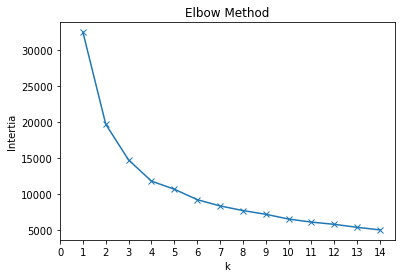

In [9]:
intertia = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    intertia.append(km.inertia_)
plt.plot(K, intertia, marker= "x")
plt.xlabel('k')
plt.xticks(np.arange(15))
plt.ylabel('Intertia')
plt.title('Elbow Method')
plt.show()

In [10]:
colze = KneeLocator(range(1, 15), intertia, curve="convex", direction="decreasing")
print('Ideal cluster number is:', colze.elbow)

Ideal cluster number is: 4


In [11]:
# Perform K-means algorithm

km = KMeans(n_clusters=4,random_state = 22, n_init= km.n_iter_, init='random')
kfit=km.fit(df)
y_kmeans = km.predict(df)

centroids = km.cluster_centers_
C = km.cluster_centers_

In [12]:
#Appending the identified clusters to the original data

pca = PCA(n_components=2)
ppcc=pca.fit_transform(df)

principalDf = pd.DataFrame(data = ppcc, columns = ['component1', 'component2'])

principalDf['Cluster'] = y_kmeans
principalDf.head()

,component1,component2,Cluster
0,-0.440288,-0.519045,0
1,-0.484587,-0.584727,0
2,-0.474171,-0.604215,0
3,-0.561535,-0.520838,0
4,-0.575633,-0.506433,0


In [13]:
expl=pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:30]))

[0.41736899 0.22314417]
suma: 0.6405131545041078


In [14]:
principalDf['Cluster'].value_counts()

1    3672
0    3462
3    3394
2    2475
Name: Cluster, dtype: int64

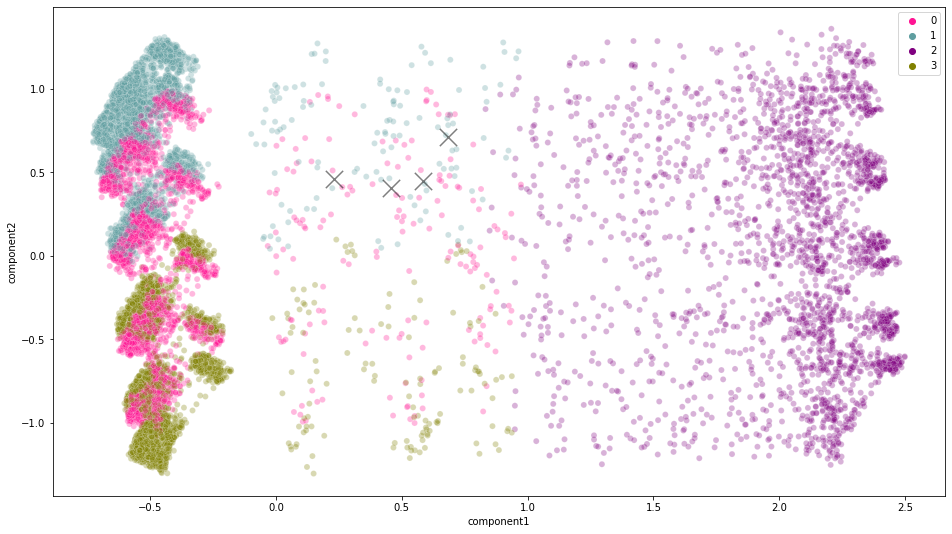

In [15]:
plt.rcParams['figure.figsize'] = (16, 9)

# Predicting the clusters
labels = km.predict(df)

colores=['deeppink','cadetblue','purple','olive']
#,'deeppink','sienna','tomato','darkcyan','cadetblue','purple','olive'
asignar=[]
for row in labels:
    asignar.append(colores[row])

sns.scatterplot(data=principalDf, x="component1", y="component2", hue= y_kmeans, palette = colores, alpha = 0.3)
centers = km.cluster_centers_# Plot centers

plt.scatter(centers[:, 0], centers[:, 1],color='k', s=300, marker="x", alpha = 0.5);

In [16]:
from sklearn import metrics
labels = km.labels_
sil=metrics.silhouette_score(df, labels, metric = 'euclidean')
if sil < 0:
    print('silhouette:',round(sil,4),'-- sample2 have been assigned to the wrong cluster')
elif sil < 0.5:
    print('silhouette:',round(sil,4),'-- overlaping samples')
else:
    print('silhouette:',round(sil,4),'-- good clustering')

silhouette: 0.333 -- overlaping samples


In [17]:
df1=df1.reset_index()
df1=df1.drop(['index'],axis=1)
df1

,sol,tmed,presMax,velmedia,dir,humidity,prec,mes
0,0.0,7.4,981.3,1.9,27.0,84.0,0.0,3
1,0.7,10.7,980.9,0.8,32.0,84.0,0.0,3
2,0.2,8.9,980.0,1.4,32.0,79.0,0.0,3
3,7.9,10.6,980.0,1.9,32.0,82.0,0.0,3
4,9.4,11.5,978.1,2.2,32.0,76.0,0.0,3
...,...,...,...,...,...,...,...,...
12998,13.1,24.8,968.5,6.4,21.0,68.0,0.0,7
12999,12.5,25.2,968.8,3.1,8.0,72.0,0.0,7
13000,12.9,25.1,968.8,3.1,20.0,72.0,0.0,7
13001,7.4,25.6,966.1,2.2,6.0,78.0,0.0,7


In [18]:
dfjoin=pd.concat([df1,principalDf['Cluster']], axis=1)
dfjoin

,sol,tmed,presMax,velmedia,dir,humidity,prec,mes,Cluster
0,0.0,7.4,981.3,1.9,27.0,84.0,0.0,3,0
1,0.7,10.7,980.9,0.8,32.0,84.0,0.0,3,0
2,0.2,8.9,980.0,1.4,32.0,79.0,0.0,3,0
3,7.9,10.6,980.0,1.9,32.0,82.0,0.0,3,0
4,9.4,11.5,978.1,2.2,32.0,76.0,0.0,3,0
...,...,...,...,...,...,...,...,...,...
12998,13.1,24.8,968.5,6.4,21.0,68.0,0.0,7,1
12999,12.5,25.2,968.8,3.1,8.0,72.0,0.0,7,1
13000,12.9,25.1,968.8,3.1,20.0,72.0,0.0,7,1
13001,7.4,25.6,966.1,2.2,6.0,78.0,0.0,7,1


In [28]:
dfjoin.groupby('Cluster')['prec'].median()

Cluster
0    0.0
1    0.0
2    3.8
3    0.0
Name: prec, dtype: float64

In [20]:
dfjoin.groupby('Cluster')['velmedia'].mean()

Cluster
0    4.075072
1    3.803949
2    4.330747
3    4.345080
Name: velmedia, dtype: float64

In [30]:
dfjoin.groupby('Cluster')['mes'].sum()

Cluster
0    12238
1    27287
2    16113
3    29133
Name: mes, dtype: int64

In [22]:
dfjoin0=dfjoin[dfjoin['Cluster'] == 0]
dfjoin1=dfjoin[dfjoin['Cluster'] == 1]
dfjoin2=dfjoin[dfjoin['Cluster'] == 2]
dfjoin3=dfjoin[dfjoin['Cluster'] == 3]


In [23]:
dfjoin0.mean()

sol           8.172704
tmed         13.409705
presMax     970.625679
velmedia      4.075072
dir          23.340266
humidity     70.672155
prec          0.008521
mes           3.534951
Cluster       0.000000
dtype: float64

In [39]:
dfjoin2['mes'].value_counts()

4     275
10    259
5     256
9     236
11    227
3     225
1     204
12    182
8     178
2     167
6     161
7     105
Name: mes, dtype: int64

In [24]:
dfjoin1.mean()

sol           9.556264
tmed         23.023448
presMax     970.462255
velmedia      3.803949
dir          22.081155
humidity     70.986383
prec          0.006073
mes           7.431100
Cluster       1.000000
dtype: float64

In [25]:
dfjoin2.mean()

sol           3.216162
tmed         13.941657
presMax     967.014141
velmedia      4.330747
dir          18.684040
humidity     78.690909
prec          8.947960
mes           6.510303
Cluster       2.000000
dtype: float64

In [26]:
dfjoin3.mean()

sol           6.381644
tmed         11.947731
presMax     972.096346
velmedia      4.345080
dir          26.664997
humidity     71.163819
prec          0.006511
mes           8.583677
Cluster       3.000000
dtype: float64